In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from helper import plot_mnist

# Notes

- maybe it's a good idea to keep some learning goals in the introduction? 

  """By the end of this notebook, you will be able to:
  - Apply clustering techniques to both image and healthcare data
  - Interpret clustering results and evaluate their quality
  - Understand how clustering can support data-driven decision-making in healthcare

  Let's get started!
  """
- I changed the dataset to the Wine Dataset, for faster computation, less datapoints etc. 
- K-means already performs really well, which does not show the usefulness of K-Medoids
- I also applied the clustering algorithms on the UMAP reduced data instead for cleaner results. We can change this if we like, should maybe try the other option too but do it at the end
- TODO: Adjust the Header sizes

# Table of Contents

<br><br>
# **Hands-On: Clustering**

In this Hands-On session, we will explore clustering, an essential unsupervised learning technique that helps us discover patterns and structure within complex datasets. Clustering algorithms can group similar data points together without any prior labels, making them invaluable for exploratory data analysis, anomaly detection, and patient stratification in healthcare.

To build a strong foundation, we will start with a new dataset on wines. Once comfortable with the techniques, we will transfer our knowledge to a real-world healthcare dataset, examining how clustering can reveal meaningful subgroups and insights in clinical data.

Let's get started!

## Introduction to the Wine Dataset

The **Wine Recognition dataset** is a classic dataset in machine learning, containing chemical analysis results of wines grown in the same region of Italy but derived from three different cultivars (grape varieties).

- **Samples:** 178 wine samples
- **Features:** 13 numeric features representing chemical properties (for example alcohol content, color intensity, flavanoids etc.)
- **Labels:** 
    - `0` = Class 0 wine (59 samples)
    - `1` = Class 1 wine (71 samples) 
    - `2` = Class 2 wine (48 samples)
- **Data type:** All features are continuous, numeric (floating-point)
- **No missing values:** The dataset is complete and ready for analysis
- **Why useful for clustering:** The three wine classes have distinct chemical profiles, making them ideal for demonstrating how clustering algorithms can discover natural groupings in data

The chemical analysis approach mirrors how we might cluster patients based on blood tests, metabolic panels, or other laboratory measurements in healthcare settings.

In [21]:
# Load the Wine dataset
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np

# Load the dataset
wine_data = load_wine()
X = wine_data.data
y = wine_data.target
feature_names = wine_data.feature_names
target_names = wine_data.target_names

# Create a DataFrame for easier exploration
df = pd.DataFrame(X, columns=feature_names)
df['wine_class'] = y

df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  wine_

In [23]:
df.describe().round(2)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
count,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00
mean,13.00,2.34,2.37,19.49,99.74,2.30,2.03,0.36,1.59,5.06,0.96,2.61,746.89,0.94
std,0.81,1.12,0.27,3.34,14.28,0.63,1.00,0.12,0.57,2.32,0.23,0.71,314.91,0.78
min,11.03,0.74,1.36,10.60,70.00,0.98,0.34,0.13,0.41,1.28,0.48,1.27,278.00,0.00
25%,12.36,1.60,2.21,17.20,88.00,1.74,1.20,0.27,1.25,3.22,0.78,1.94,500.50,0.00
50%,13.05,1.87,2.36,19.50,98.00,2.36,2.13,0.34,1.56,4.69,0.96,2.78,673.50,1.00
75%,13.68,3.08,2.56,21.50,107.00,2.80,2.88,0.44,1.95,6.20,1.12,3.17,985.00,2.00
max,14.83,5.80,3.23,30.00,162.00,3.88,5.08,0.66,3.58,13.00,1.71,4.00,1680.00,2.00


In [24]:
# Missing values check
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
wine_class                      0
dtype: int64

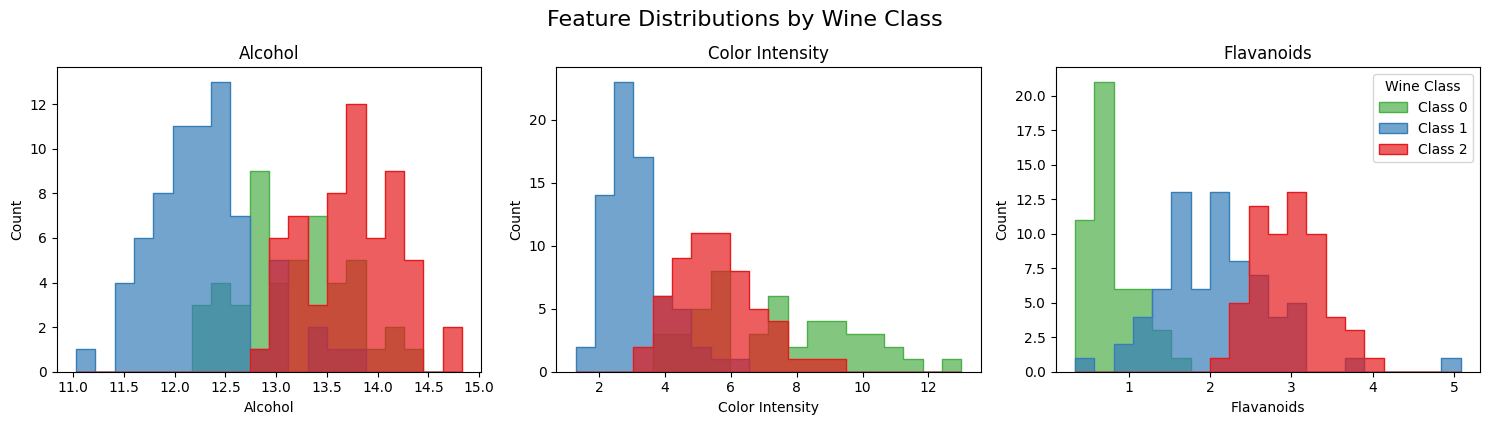

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame for easier plotting
df = pd.DataFrame(X, columns=feature_names)
df['wine_class'] = y

# Visualize distributions of key features, colored by wine class
plt.figure(figsize=(15, 4))
for i, feat in enumerate(['alcohol', 'color_intensity', 'flavanoids']):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=feat, hue='wine_class', palette='Set1', bins=20, alpha=0.7, 
                 legend=(i==2), element="step")
    plt.title(feat.replace('_', ' ').title())
    plt.xlabel(feat.replace('_', ' ').title())
    plt.ylabel('Count')
    if i == 2:
        plt.legend(labels=[f'Class {i}' for i in range(3)], title='Wine Class')
plt.tight_layout()
plt.suptitle("Feature Distributions by Wine Class", fontsize=16, y=1.05)
plt.show()

# K-Means/K-Medoids Clustering

**K-Means Clustering** is a simple approach for partitioning a dataset into *K* distinct, non-overlapping clusters.

### Key Characteristics:
- **Must specify K beforehand** - You need to decide how many clusters to find
- **Centroid-based** - Each cluster is represented by its center point (centroid)
- **Iterative algorithm** - Repeats steps until convergence
- **Assumes spherical clusters** - Works best when clusters are roughly round and similar sizes

### How K-Means Works:

**Step 1: Initialize**
- Choose *K* random starting points as initial cluster centroids
- Common methods: random points, K-means++ (smarter initialization)

**Step 2: Assignment**
- For each data point, calculate distance to all centroids
- Assign each point to the closest centroid's cluster

**Step 3: Update**
- Calculate the mean (centroid) of all points in each cluster
- Move the centroid to this new mean position

**Step 4: Repeat**
- Repeat steps 2-3 until convergence:
  - Centroids stop moving significantly, OR
  - Cluster assignments stop changing, OR
  - Maximum iterations reached

### For Our Wine Dataset:
- We know there are **K=3** wine classes (different grape cultivars)
- K-Means should discover these 3 natural groups based on chemical properties
- We'll see if the algorithm can separate wines without knowing the true labels!

Let's see how well K-Means performs on our Wine dataset and visualize the clustering process step by step!

c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


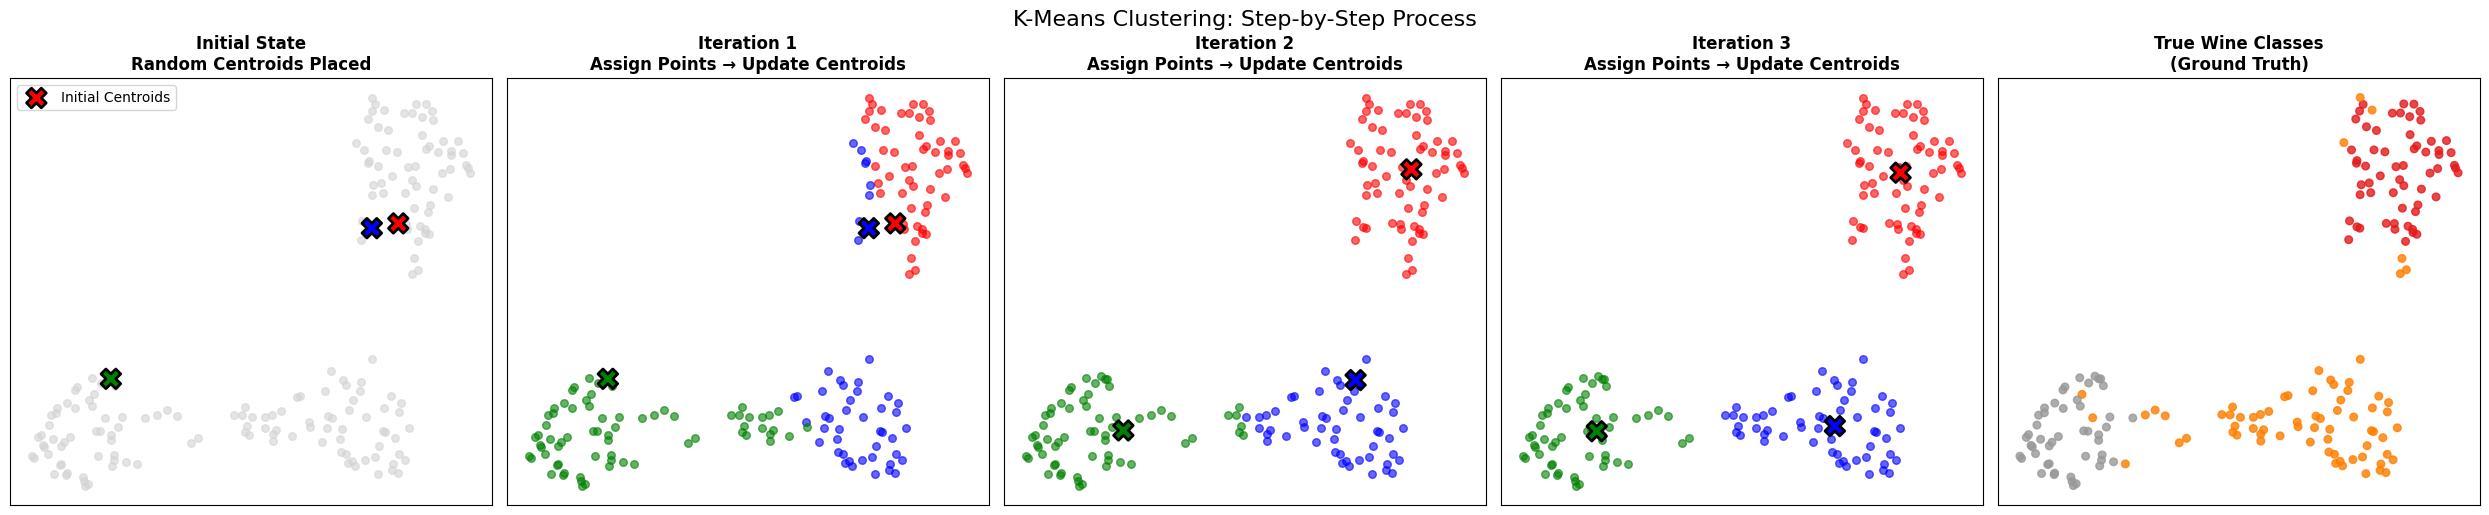

📋 K-MEANS STEP-BY-STEP PROCESS:
🎯 Initial State: 3 random centroids placed
🔄 Iteration 1: Points assigned to nearest centroid → centroids updated
🔄 Iteration 2: Points reassigned → centroids moved again
🔄 Iteration 3: Algorithm converging → centroids stabilizing
✅ Final: Compare with true wine classes!

💡 Key Observations:
• Centroids move toward the center of their assigned points
• Cluster boundaries become more defined with each iteration
• Algorithm converges when centroids stop moving significantly


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from umap import UMAP

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP for 2D visualization
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap.fit_transform(X_scaled)

# Manual K-Means implementation for step-by-step visualization
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def assign_clusters(X, centroids):
    clusters = []
    for point in X:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        cluster = np.argmin(distances)
        clusters.append(cluster)
    return np.array(clusters)

def update_centroids(X, clusters, k):
    centroids = []
    for i in range(k):
        cluster_points = X[clusters == i]
        if len(cluster_points) > 0:
            centroid = np.mean(cluster_points, axis=0)
        else:
            centroid = X[np.random.randint(0, len(X))]  # Handle empty clusters
        centroids.append(centroid)
    return np.array(centroids)

# Initialize K=3 random centroids
np.random.seed(42)
k = 3
initial_centroids = X_umap[np.random.choice(X_umap.shape[0], k, replace=False)]

# Colors for visualization
colors = ['red', 'blue', 'green']

# Step-by-step K-Means
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

centroids = initial_centroids.copy()

for iteration in range(5):  # 0=initial, 1-3=iterations, 4=true classes
    
    if iteration == 0:
        # Initial state
        axes[iteration].scatter(X_umap[:, 0], X_umap[:, 1], c='lightgray', s=30, alpha=0.6)
        axes[iteration].scatter(centroids[:, 0], centroids[:, 1], c=colors, s=200, marker='X', 
                              edgecolors='black', linewidth=2, label='Initial Centroids')
        axes[iteration].set_title(f'Initial State\nRandom Centroids Placed', fontsize=12, fontweight='bold')
        axes[iteration].legend()
    elif iteration <= 3:
        # Assign points to clusters
        clusters = assign_clusters(X_umap, centroids)
        
        # Plot points colored by cluster assignment
        for i in range(k):
            mask = clusters == i
            axes[iteration].scatter(X_umap[mask, 0], X_umap[mask, 1], c=colors[i], s=30, alpha=0.6)
        
        # Plot centroids
        axes[iteration].scatter(centroids[:, 0], centroids[:, 1], c=colors, s=200, marker='X', 
                              edgecolors='black', linewidth=2)
        
        axes[iteration].set_title(f'Iteration {iteration}\nAssign Points → Update Centroids', 
                                fontsize=12, fontweight='bold')
        
        # Update centroids for next iteration
        if iteration < 3:
            centroids = update_centroids(X_umap, clusters, k)
    else:
        # Show true wine classes for comparison
        axes[iteration].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='Set1', s=30, alpha=0.8)
        axes[iteration].set_title('True Wine Classes\n(Ground Truth)', fontsize=12, fontweight='bold')
    
    axes[iteration].set_xticks([])
    axes[iteration].set_yticks([])
    axes[iteration].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('K-Means Clustering: Step-by-Step Process', fontsize=16, y=1.02)
plt.show()

**Key Observations**:
- Centroids move toward the center of their assigned points
- Already after 3 iterations, the resulting clusters look very similar to the Ground Truth!

Let's use KMeans now with the *Scikit-learn* package!

c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


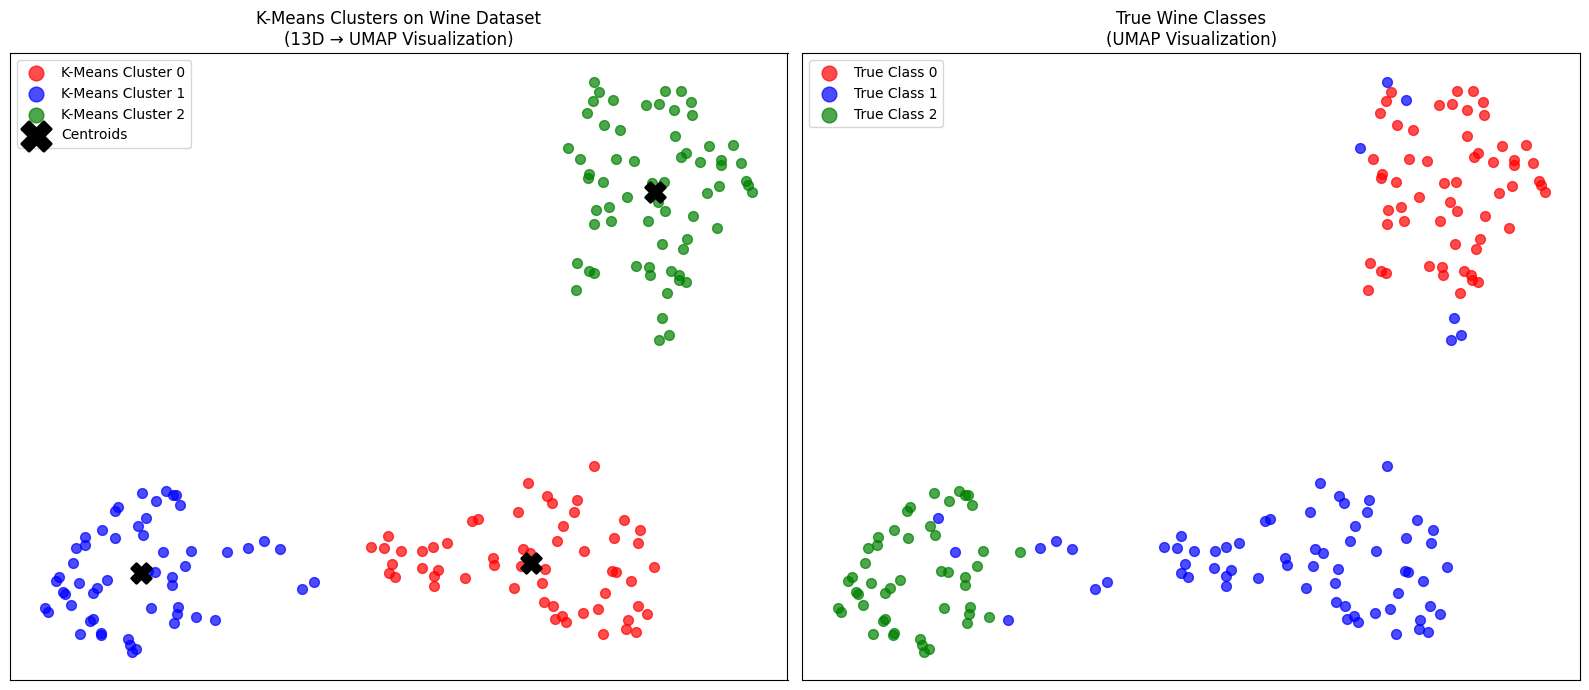

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from umap import UMAP

# TODO Remove this code block because we used it before

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP for visualization
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap.fit_transform(X_scaled)

# K-Means clustering on original high-dimensional data (13 features)
kmeans = KMeans(n_clusters=3, random_state=42,)
kmeans.fit(X_umap)  # Cluster on original 13D data

# Prepare colors for 3 clusters/classes
colors = ['red', 'blue', 'green']
wine_class_names = ['Class 0', 'Class 1', 'Class 2']

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# --- K-Means subplot ---
for i in range(3):
    idx = kmeans.labels_ == i
    axs[0].scatter(X_umap[idx, 0], X_umap[idx, 1], s=50, alpha=0.7, 
                   color=colors[i], label=f"K-Means Cluster {i}")

# Plot cluster centroids projected to UMAP space
centroids_umap = kmeans.cluster_centers_ #umap.transform(kmeans.cluster_centers_)
axs[0].scatter(centroids_umap[:, 0], centroids_umap[:, 1], 
               c='black', marker='X', s=200, linewidth=2, label='Centroids')

axs[0].set_title('K-Means Clusters on Wine Dataset\n(13D → UMAP Visualization)', fontsize=12)
axs[0].legend(markerscale=1.5)

# --- True Labels subplot ---
for i in range(3):
    idx = y == i
    axs[1].scatter(X_umap[idx, 0], X_umap[idx, 1], s=50, alpha=0.7, 
                   color=colors[i], label=f"True {wine_class_names[i]}")

axs[1].set_title('True Wine Classes\n(UMAP Visualization)', fontsize=12)
axs[1].legend(markerscale=1.5)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## From K-Means to K-Medoids

K-Means worked well, but let's explore **K-Medoids (PAM)** - a more robust alternative.

### Key Differences:

- **Cluster centers**: K-Means uses calculated centroids vs K-Medoids uses actual data points (medoids)
- **Outlier sensitivity**: K-Medoids is more robust to outliers than K-Means
- **Distance metrics**: K-Medoids can use any distance metric, K-Means is limited to Euclidean

### When to Use K-Medoids:

- **Noisy data** with outliers
- **Better interpretability** - medoids are real wine samples
- **Non-Euclidean data** where averaging doesn't make sense

Let's apply K-Medoids to our wine dataset and compare the results!

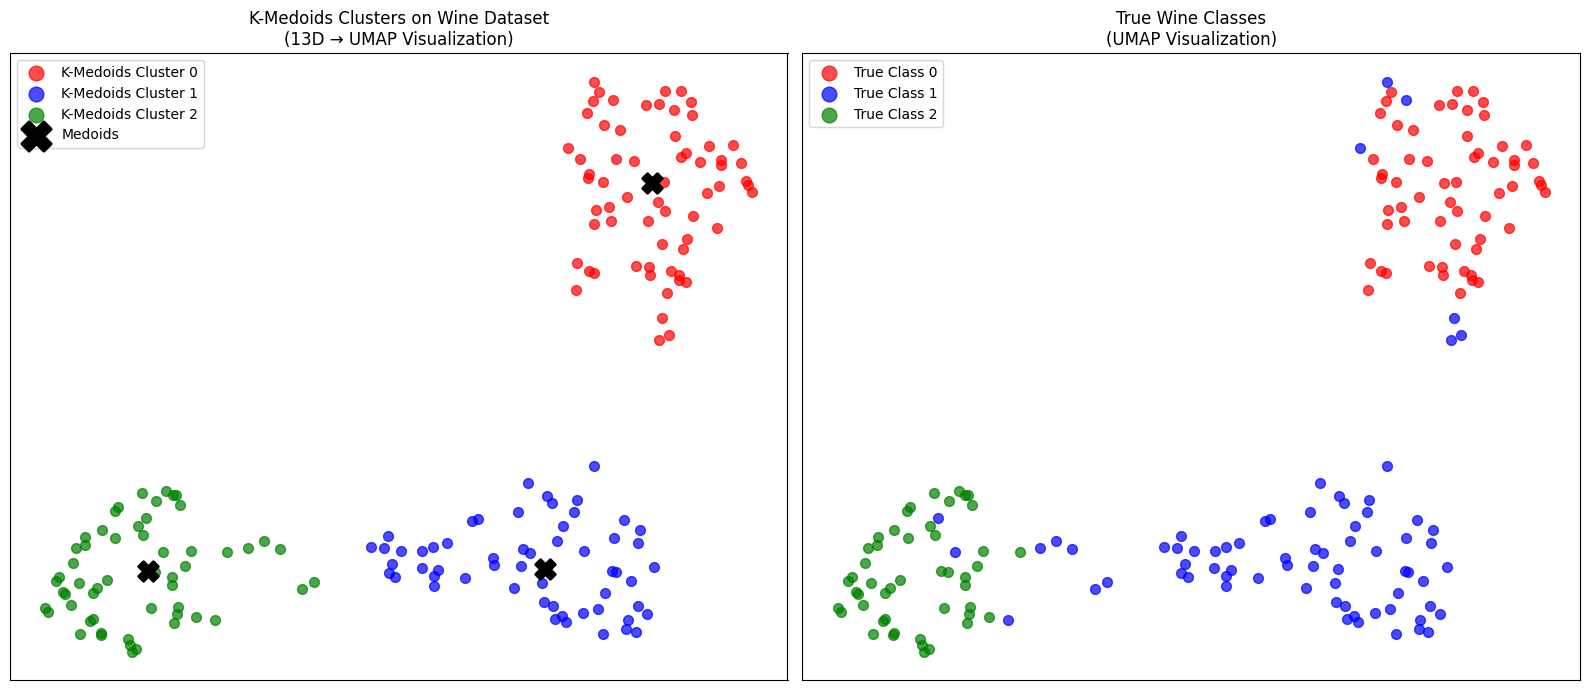

In [ ]:
import kmedoids
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances, adjusted_rand_score, silhouette_score

# K-Medoids clustering on original high-dimensional data (13 chemical features)
kmed = kmedoids.KMedoids(n_clusters=3, random_state=42)
euclidean_dist = pairwise_distances(X_umap, metric='euclidean')

kmed.fit(euclidean_dist)

# Prepare colors for 3 clusters/classes
colors = ['red', 'blue', 'green']
wine_class_names = ['Class 0', 'Class 1', 'Class 2']

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# --- K-Medoids subplot ---
for i in range(3):
    idx = kmed.labels_ == i
    axs[0].scatter(X_umap[idx, 0], X_umap[idx, 1], s=50, alpha=0.7, 
                   color=colors[i], label=f"K-Medoids Cluster {i}")

# Plot medoids (actual wine samples that are cluster centers)
medoids_umap = X_umap[kmed.medoid_indices_]
axs[0].scatter(medoids_umap[:, 0], medoids_umap[:, 1], 
               c='black', marker='X', s=200, linewidth=2, label='Medoids')

axs[0].set_title('K-Medoids Clusters on Wine Dataset\n(13D → UMAP Visualization)', fontsize=12)
axs[0].legend(markerscale=1.5)

# --- True Labels subplot ---
for i in range(3):
    idx = y == i
    axs[1].scatter(X_umap[idx, 0], X_umap[idx, 1], s=50, alpha=0.7, 
                   color=colors[i], label=f"True {wine_class_names[i]}")

axs[1].set_title('True Wine Classes\n(UMAP Visualization)', fontsize=12)
axs[1].legend(markerscale=1.5)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance evaluation
#ari_medoids = adjusted_rand_score(y, kmed.labels_)
#silhouette_medoids = silhouette_score(X_scaled, kmed.labels_)

#print("🍷 K-MEDOIDS CLUSTERING RESULTS:")
#print("=" * 45)
#print(f"📊 Clustering performed on original 13-dimensional chemical data")
#print(f"🎯 UMAP used only for 2D visualization of results")
#print(f"🔬 Medoids are actual wine samples (indices: {kmed.medoid_indices_})")
#print(f"\n📈 PERFORMANCE METRICS:")
#print(f"- Adjusted Rand Index: {ari_medoids:.3f}")
#print(f"- Silhouette Score: {silhouette_medoids:.3f}")
#print(f"\n🆚 COMPARISON WITH K-MEANS:")
#print(f"- K-Means ARI: {ari:.3f} vs K-Medoids ARI: {ari_medoids:.3f}")
#print(f"- K-Means Silhouette: {silhouette:.3f} vs K-Medoids Silhouette: {silhouette_medoids:.3f}")

#if ari_medoids > ari:
#    print("✅ K-Medoids performed better!")
#elif abs(ari_medoids - ari) < 0.05:
#    print("⚖️  Similar performance - both methods work well")
#else:
#    print("✅ K-Means performed better!")

## K-Means vs K-Medoids: Comparison

### Similarities:
- Both are partitional clustering methods that divide data into K clusters
- Must specify K beforehand
- Iterative algorithms with assignment and update steps
- Sensitive to initialization and assume similar cluster sizes

### Key Differences:

| Aspect | K-Means | K-Medoids |
|--------|---------|-----------|
| **Cluster Centers** | Calculated centroids | Actual data points |
| **Outlier Sensitivity** | High | Low |
| **Distance Metrics** | Euclidean only | Any metric |
| **Speed** | Faster | Slower |
| **Interpretability** | Centroids may not exist | Medoids are real samples |

### When to Use:

**K-Means:**
- Large datasets (computational efficiency)
- Clean data without outliers
- All continuous features

**K-Medoids:**
- Noisy data with outliers
- Need interpretable cluster centers
- Mixed data types or non-Euclidean distances

### For Wine Dataset:
Both performed well due to clean data, moderate size, and well-separated chemical profiles. Choice depends on specific requirements.

# Hierarchical Clustering

K-Means and K-Medoids come with the disadvantage that we need to specify the number of clusters *K* present before running the algorithm. An alternative approach that does not require a previously defined choice of *K* is **Hierarchical Clustering**. Additionally Hierarchical Clustering provides an attractive tree-based representation of the observations, called a *dendogram*. 

We describe first the *agglomerative/bottom-up* clustering approach, where we build the dendogramm by combining two close leaves (datapoints) iteratively until we have built a tree. 

In [4]:
# Prepare dataset for hierarchical clustering
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from umap import UMAP
import string
from scipy.cluster.hierarchy import dendrogram, linkage

# Assuming mnist.data and mnist.target are loaded
X = mnist.data[:5000]  # Using subset for hierarchical clustering
y_subset = mnist.target[:5000]  # Use corresponding subset of labels

# Apply UMAP for dimensionality reduction BEFORE clustering
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap.fit_transform(X)

# Prepare colors and cluster labels
cmap = plt.get_cmap('tab10', 10)
colors = [cmap(i) for i in range(10)]
cluster_letters = list(string.ascii_uppercase[:10])

print("✅ Data prepared and reduced to 2D using UMAP")
print(f"Original shape: {X.shape} → UMAP shape: {X_umap.shape}")

c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Data prepared and reduced to 2D using UMAP
Original shape: (5000, 784) → UMAP shape: (5000, 2)


### Ward's Method


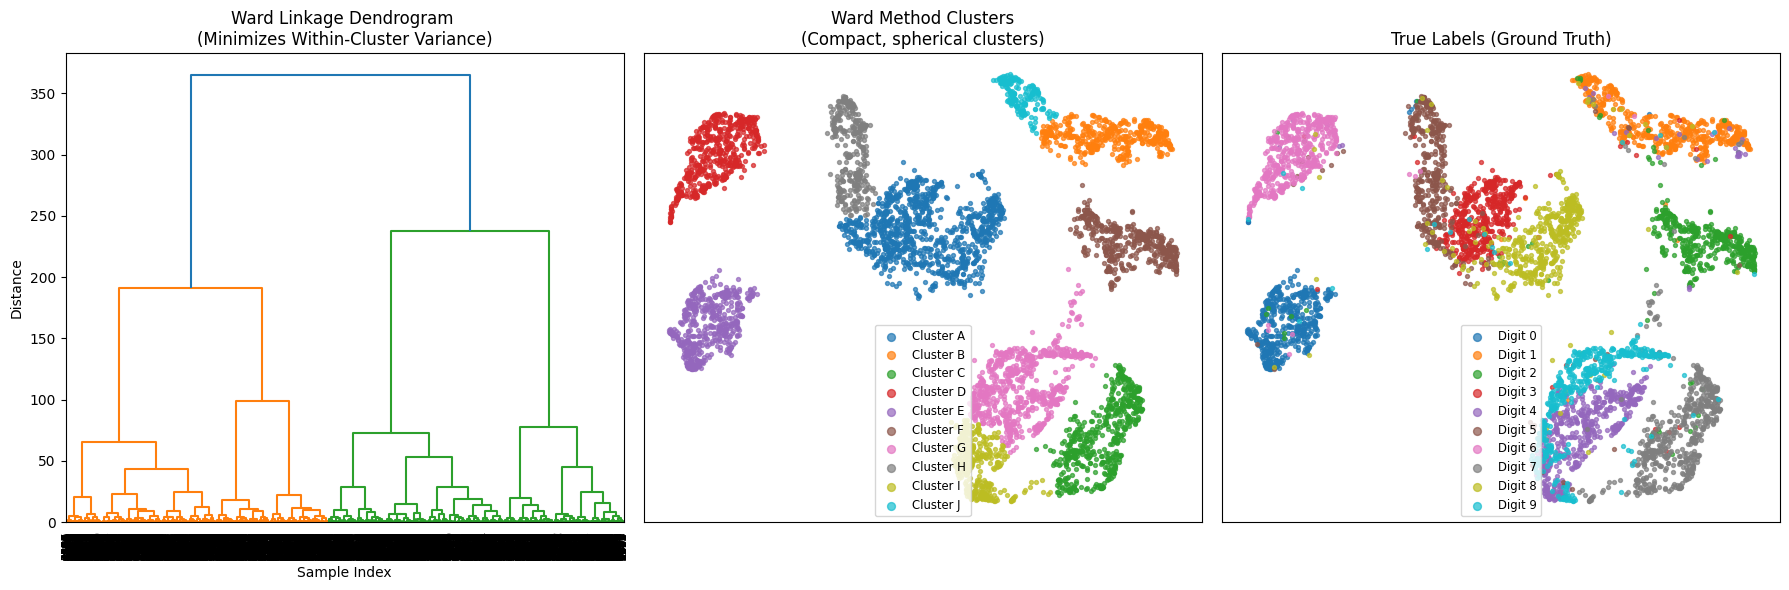

🔗 WARD'S METHOD:
• Best for compact, roughly equal-sized clusters
• Minimizes within-cluster sum of squares
• Most commonly used in healthcare applications


In [ ]:
# Ward's method - minimizes within-cluster variance
hierarchical_ward = AgglomerativeClustering(n_clusters=10, linkage='ward')
ward_labels = hierarchical_ward.fit_predict(X_umap)

# Create visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Dendrogram using subset of 50 samples for clarity
X_dendro_subset = X_umap#[:50]  # Use first 50 samples for dendrogram
linkage_matrix_ward = linkage(X_dendro_subset, method='ward')
dendrogram(linkage_matrix_ward, ax=axs[0], 
           leaf_rotation=90, leaf_font_size=8)
axs[0].set_title('Ward Linkage Dendrogram \n(Minimizes Within-Cluster Variance)', fontsize=12)
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Distance')

# Ward clusters
for i in range(10):
    idx = ward_labels == i
    axs[1].scatter(X_umap[idx, 0], X_umap[idx, 1], s=8, alpha=0.7, 
                   color=colors[i], label=f"Cluster {cluster_letters[i]}")
axs[1].set_title('Ward Method Clusters\n(Compact, spherical clusters)')
axs[1].legend(markerscale=2, fontsize="small")
axs[1].set_xticks([])
axs[1].set_yticks([])

# True labels for comparison
for i in range(10):
    idx = y_subset.astype(int) == i
    axs[2].scatter(X_umap[idx, 0], X_umap[idx, 1], s=8, alpha=0.7, 
                   color=colors[i], label=f"Digit {i}")
axs[2].set_title('True Labels (Ground Truth)')
axs[2].legend(markerscale=2, fontsize="small")
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.tight_layout()
plt.show()

print("🔗 WARD'S METHOD:")
print("- Best for compact, roughly equal-sized clusters")
print("- Minimizes within-cluster sum of squares")
print("- Most commonly used in healthcare applications")

### Single Linkage

In [ ]:
# Single linkage - connects clusters based on closest points
hierarchical_single = AgglomerativeClustering(n_clusters=10, linkage='single')
single_labels = hierarchical_single.fit_predict(X_umap)

# Create visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Dendrogram
linkage_matrix_single = linkage(X_umap, method='single')
dendrogram(linkage_matrix_single, ax=axs[0], truncate_mode='level', p=10, 
           leaf_rotation=90, leaf_font_size=8)
axs[0].set_title('Single Linkage Dendrogram\n(Connects Nearest Points)', fontsize=12)
axs[0].set_xlabel('Sample Index (or Cluster Size)')
axs[0].set_ylabel('Distance')

# Single linkage clusters
for i in range(10):
    idx = single_labels == i
    axs[1].scatter(X_umap[idx, 0], X_umap[idx, 1], s=8, alpha=0.7, 
                   color=colors[i], label=f"Cluster {cluster_letters[i]}")
axs[1].set_title('Single Linkage Clusters\n(Can create elongated clusters)')
axs[1].legend(markerscale=2, fontsize="small")
axs[1].set_xticks([])
axs[1].set_yticks([])

# True labels for comparison
for i in range(10):
    idx = y_subset.astype(int) == i
    axs[2].scatter(X_umap[idx, 0], X_umap[idx, 1], s=8, alpha=0.7, 
                   color=colors[i], label=f"Digit {i}")
axs[2].set_title('True Labels (Ground Truth)')
axs[2].legend(markerscale=2, fontsize="small")
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.tight_layout()
plt.show()

print("🔗 SINGLE LINKAGE:")
print("- Connects clusters via their closest points")
print("- Can detect elongated, chain-like clusters")
print("- Prone to 'chaining effect' - may create unbalanced clusters")
print("- Useful for detecting irregular cluster shapes")

### Complete Linkage

In [ ]:
# Complete linkage - connects clusters based on farthest points
hierarchical_complete = AgglomerativeClustering(n_clusters=10, linkage='complete')
complete_labels = hierarchical_complete.fit_predict(X_umap)

# Create visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Dendrogram
linkage_matrix_complete = linkage(X_umap, method='complete')
dendrogram(linkage_matrix_complete, ax=axs[0], truncate_mode='level', p=10, 
           leaf_rotation=90, leaf_font_size=8)
axs[0].set_title('Complete Linkage Dendrogram\n(Connects Farthest Points)', fontsize=12)
axs[0].set_xlabel('Sample Index (or Cluster Size)')
axs[0].set_ylabel('Distance')

# Complete linkage clusters
for i in range(10):
    idx = complete_labels == i
    axs[1].scatter(X_umap[idx, 0], X_umap[idx, 1], s=8, alpha=0.7, 
                   color=colors[i], label=f"Cluster {cluster_letters[i]}")
axs[1].set_title('Complete Linkage Clusters\n(Compact, well-separated clusters)')
axs[1].legend(markerscale=2, fontsize="small")
axs[1].set_xticks([])
axs[1].set_yticks([])

# True labels for comparison
for i in range(10):
    idx = y_subset.astype(int) == i
    axs[2].scatter(X_umap[idx, 0], X_umap[idx, 1], s=8, alpha=0.7, 
                   color=colors[i], label=f"Digit {i}")
axs[2].set_title('True Labels (Ground Truth)')
axs[2].legend(markerscale=2, fontsize="small")
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.tight_layout()
plt.show()

print("🔗 COMPLETE LINKAGE:")
print("- Connects clusters via their farthest points")
print("- Creates compact, well-separated clusters")
print("- Less sensitive to outliers than single linkage")
print("- Good for finding spherical clusters of similar size")

### Average Linkage

In [ ]:
# Average linkage - connects clusters based on average distance between all points
hierarchical_average = AgglomerativeClustering(n_clusters=10, linkage='average')
average_labels = hierarchical_average.fit_predict(X_umap)

# Create visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Dendrogram
linkage_matrix_average = linkage(X_umap, method='average')
dendrogram(linkage_matrix_average, ax=axs[0], truncate_mode='level', p=10, 
           leaf_rotation=90, leaf_font_size=8)
axs[0].set_title('Average Linkage Dendrogram\n(Average Distance Between Clusters)', fontsize=12)
axs[0].set_xlabel('Sample Index (or Cluster Size)')
axs[0].set_ylabel('Distance')

# Average linkage clusters
for i in range(10):
    idx = average_labels == i
    axs[1].scatter(X_umap[idx, 0], X_umap[idx, 1], s=8, alpha=0.7, 
                   color=colors[i], label=f"Cluster {cluster_letters[i]}")
axs[1].set_title('Average Linkage Clusters\n(Balanced approach)')
axs[1].legend(markerscale=2, fontsize="small")
axs[1].set_xticks([])
axs[1].set_yticks([])

# True labels for comparison
for i in range(10):
    idx = y_subset.astype(int) == i
    axs[2].scatter(X_umap[idx, 0], X_umap[idx, 1], s=8, alpha=0.7, 
                   color=colors[i], label=f"Digit {i}")
axs[2].set_title('True Labels (Ground Truth)')
axs[2].legend(markerscale=2, fontsize="small")
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.tight_layout()
plt.show()

print("🔗 AVERAGE LINKAGE:")
print("- Connects clusters based on average distance between all points")
print("- Compromise between single and complete linkage")
print("- Less extreme than single or complete linkage")
print("- Good general-purpose method for most applications")

## DBSCAN

## Overview

# Transfer to Clinical Dataset

## Dataset Description

## K-Means

## Hierarchical Clustering

## DBSCAN

## Overview